# XOPT - INTERPRETABLE METAHEURISTICS FOR COMBINATORIAL OPTIMIZATION

## EXPLORATORY ANALYSIS

This notebook demonstrates how to compile and use the Python extension `xopt` to solve instances of the p-median problem with the `kmedoids` and `tspmed` algorithms.

### SETTING THE ENVIRONMENT

Importing the libraries:

In [1]:
import xopt
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

This cell locates the "instances" folder in the project root and counts how many p-median instance files exist:

In [2]:
ROOT          = Path.cwd().resolve().parent
INSTANCES_DIR = ROOT / "instances"

if not INSTANCES_DIR.exists():
    raise FileNotFoundError(f"Instances folder not found: {INSTANCES_DIR}")

print(f"Total number of p-median instances: {len(list(INSTANCES_DIR.glob('pmed[0-9]*.txt')))}")

Total number of p-median instances: 40


### AUXILIARY FUNCTIONS

We define utilities to load instances, run the algorithms, and organize the results into user-friendly structures:

In [3]:
def to_one_based(indices):
    return [v + 1 for v in indices]

def to_binary(indices, n):
    binary = [0] * n
    for i in indices:
        binary[i] = 1

    return binary


def solve_pmedian(instance_path, *, restarts=10, max_iter=20, factor=2):
    instance = xopt.Instance(instance_path)

    n = instance.get_n()
    p = instance.get_p()

    medoids_runs = xopt.kmedoids(
        instance,
        max_iter=max_iter,
        restarts=restarts,
    )

    long_term  = xopt.SolutionTrie(n, p)

    ts_results = []
    for medoids_run in medoids_runs:
        ts_results.append(
            xopt.tspmed(
                instance           ,
                medoids_run.medoids,
                iter_factor=factor ,
                long_term=long_term,
            )
        )

    best_kmedoids      = min(medoids_runs, key=lambda run: run.cost)
    best_tspmed_result = min(ts_results  , key=lambda run: run.best.cost)
    best_tspmed        = best_tspmed_result.best
    long_term_mem      = long_term.get_all_solutions(instance)

    summary = {
        "instance" : instance_path,
        "n"        : n,
        "p"        : p,

        "kmedoids_cost" : best_kmedoids.cost,
        "medoids"       : to_one_based(best_kmedoids.medoids),

        "long_term_mem"     : len(long_term_mem),
        "tspmed_cost"       : best_tspmed.cost,
        "tspmed_facilities" : to_one_based(best_tspmed.facilities),
    }

    details = {
        "medoids": [
            {
                "restart" : idx,
                "cost"    : run.cost,
                "medoids" : to_binary(run.medoids, n),
            }
            for idx, run in enumerate(medoids_runs)
        ],
        "long_term_memory": [
            {
                "cost"       : sol.cost,
                "facilities" : to_binary(sol.facilities, n),
            }
            for sol in long_term_mem
        ],
        "tspmed": [
            {
                "restart"    : idx,
                "cost"       : result.best.cost,
                "facilities" : to_binary(result.best.facilities, n),
            }
            for idx, result in enumerate(ts_results)
        ],
    }

    return summary, details

### TESTING

We selected a few classic p-median instances and recorded the results obtained:

In [4]:
instance      = "pmed1.txt"
instance_path = str(INSTANCES_DIR / instance)

summary, details = solve_pmedian (instance_path,
                                  restarts=8 ,
                                  max_iter=25,
                                  factor=2   )

print(f"Instance {summary['instance'][:-4]} ({summary['p']}-{summary['n']})")

print()
print(f"  K-Medoids ({summary['kmedoids_cost']}): {summary['medoids'][:10]}"          )
print(f"  TSPMED    ({summary['tspmed_cost'  ]}): {summary['tspmed_facilities'][:10]}")

print()
print(f"Obs.: Distinct solutions recorded in long term memory is {summary['long_term_mem']}!")

Instance /home/rei-luisinho/xopt/instances/pmed1 (5-100)

  K-Medoids (5819.0): [7, 13, 91, 99, 65]
  TSPMED    (5819.0): [7, 13, 91, 99, 65]

Obs.: Distinct solutions recorded in long term memory is 249!


### LONG-TERM MEMORY

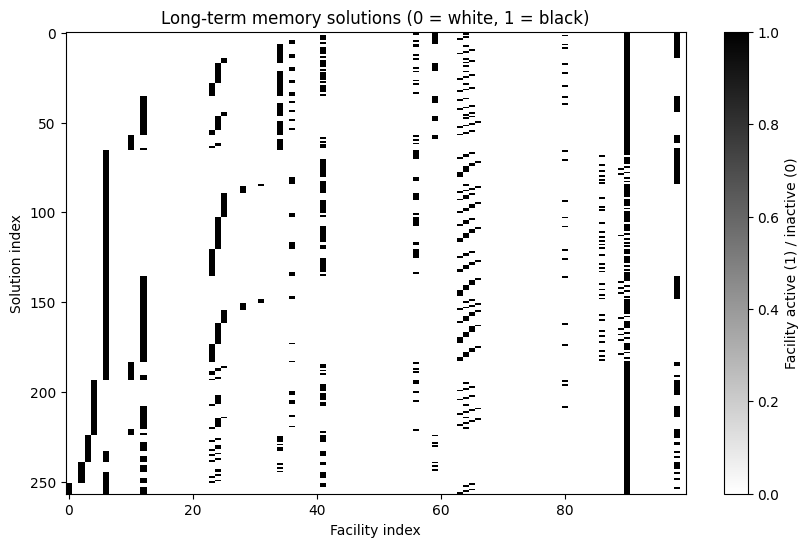

In [8]:
solutions = details["long_term_memory"]
matrix    = np.vstack(
    [
        np.array(sol["facilities"])
        for sol in solutions
    ]
)

plt.figure(figsize=(10, 6))
plt.imshow(matrix, cmap="binary", aspect="auto", interpolation="nearest")

plt.xlabel("Facility index")
plt.ylabel("Solution index")
plt.title("Long-term memory solutions (0 = white, 1 = black)")
plt.colorbar(label="Facility active (1) / inactive (0)")

plt.show()